In [1]:
import jax.numpy as jnp
import numpy as np
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_default_device", jax.devices()[3])

import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from EquationModel import OperatorModel,OperatorPDEModel
from evaluation_metrics import compute_results    
from data_utils import MinMaxScaler
from evaluation_metrics import get_nrmse

from Kernels import log1pexp,inv_log1pexp, get_gaussianRBF
from Kernels import (
    get_centered_scaled_poly_kernel,
    get_anisotropic_gaussianRBF,
    fit_kernel_params
)
from EquationModel import CholInducedRKHS, OperatorPDEModel
from functools import partial

from Optimizers.full_jacobian import CholeskyLM, SVD_LM
from Optimizers.solvers_base import *

# import Optimizers
# import importlib
# importlib.reload(Optimizers)
# from Optimizers import CholeskyLM,SVD_LM,SketchedLM

import time
from jax.scipy.sparse.linalg import cg
from jax.scipy.linalg import solve,cho_factor,cho_solve

# import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from scipy.spatial import distance
from matplotlib import cm
import time
from mpl_toolkits.mplot3d import Axes3D
# from pyDOE import lhs
# #    import sobol_seq
import os
from parabolic_data_utils import (
    build_burgers_data,build_tx_grid,
    build_tx_grid_chebyshev,setup_problem_data,
    GP_Sampler_1D_Pinned
)
from plotting import plot_input_data,plot_compare_error
from evaluation_metrics import compute_results
import matplotlib.pyplot as plt

from matplotlib import ticker
plt.style.use("default")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'font.size': 20
})

/home/juanfelipe/anaconda3/envs/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Errors

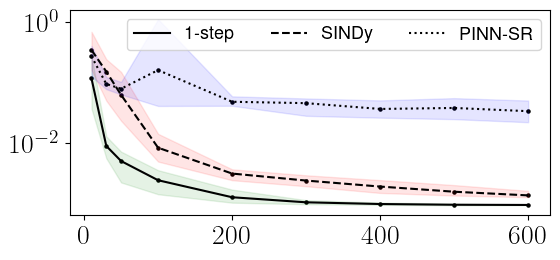

In [2]:
# u filtering error vs. N
plt.figure(figsize=(6,3))
N_OBS = [10,30,50,100,200,300,400,500,600]
##### 1 step
errors_1_5 = jnp.load('../i_smpl_errors/e_ismpl_1_5.npy', allow_pickle=True).item()
u_s = jnp.array([jnp.mean(jnp.array(el)) for el in errors_1_5['u']])
u_upper = jnp.array([jnp.nanmax(jnp.array(el)) for el in errors_1_5['u']])
u_lower = jnp.array([jnp.nanmin(jnp.array(el)) for el in errors_1_5['u']])
plt.plot(N_OBS,u_s, color = 'black', label = '1-step')
plt.scatter(N_OBS,u_s, s = 5, color = 'black')
plt.fill_between(N_OBS, u_lower, u_upper, alpha=.1, color = 'green')
##### SINDy
errors_SINDy = jnp.load('../i_smpl_errors/e_ismpl_SINDy.npy', allow_pickle=True).item()
u_s = jnp.array([jnp.mean(jnp.array(el)) for el in errors_SINDy['u']])
u_upper = jnp.array([jnp.nanmax(jnp.array(el)) for el in errors_SINDy['u']])
u_lower = jnp.array([jnp.nanmin(jnp.array(el)) for el in errors_SINDy['u']])
plt.plot(N_OBS,u_s,color = 'black', label = 'SINDy',linestyle='dashed')
plt.scatter(N_OBS,u_s,s = 5, color = 'black')
plt.fill_between(N_OBS, u_lower, u_upper, alpha=.1, color = 'red')
##### PINNSR
errors_PINNSR = jnp.load('../i_smpl_errors/e_ismpl_PINNSR.npy', allow_pickle=True).item()
u_s = jnp.array([jnp.mean(jnp.array(el)) for el in errors_PINNSR['u']])
u_upper = jnp.array([jnp.nanmax(jnp.array(el)) for el in errors_PINNSR['u']])
u_lower = jnp.array([jnp.nanmin(jnp.array(el)) for el in errors_PINNSR['u']])
plt.plot(N_OBS,u_s,color = 'black', label = 'PINN-SR',linestyle='dotted')
plt.scatter(N_OBS,u_s,s = 5, color = 'black')
plt.fill_between(N_OBS, u_lower, u_upper, alpha=.1, color = 'blue')

# fig settings
plt.yscale('log')
plt.minorticks_off()
plt.legend(fontsize=13,loc='upper right', ncol=3)
plt.tight_layout()

# save fig
plt.savefig('u_errors_fixedIC.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            )

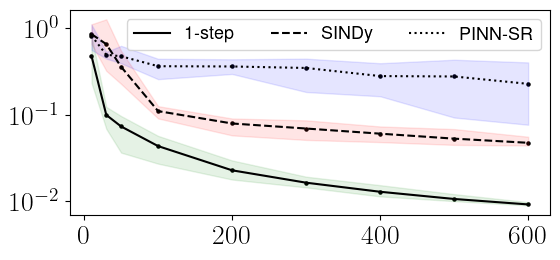

In [3]:
# P eql error vs. N
plt.figure(figsize=(6,3))
N_OBS = [10,30,50,100,200,300,400,500,600]
##### 1 step
errors_1_5 = jnp.load('../i_smpl_errors/e_ismpl_1_5.npy', allow_pickle=True).item()
P_s = jnp.array([jnp.mean(jnp.array(el)) for el in errors_1_5['Phat']])
P_lower = jnp.array([jnp.min(jnp.array(el)) for el in errors_1_5['Phat']])
P_upper = jnp.array([jnp.max(jnp.array(el)) for el in errors_1_5['Phat']])
plt.plot(N_OBS,P_s,color = 'black', label = '1-step')
plt.scatter(N_OBS,P_s,s = 5, color = 'black')
plt.fill_between(N_OBS, P_lower, P_upper, alpha=.1, color = 'green')
##### SINDy
errors_SINDy = jnp.load('../i_smpl_errors/e_ismpl_SINDy.npy', allow_pickle=True).item()
P_s = jnp.array([jnp.mean(jnp.array(el)) for el in errors_SINDy['Phat']])
P_lower = jnp.array([jnp.min(jnp.array(el)) for el in errors_SINDy['Phat']])
P_upper = jnp.array([jnp.max(jnp.array(el)) for el in errors_SINDy['Phat']])
plt.plot(N_OBS,P_s,color = 'black', label = 'SINDy',linestyle='dashed')
plt.scatter(N_OBS,P_s,s = 5, color = 'black')
plt.fill_between(N_OBS, P_lower, P_upper, alpha=.1, color = 'red')
##### PINNSR
errors_PINNSR = jnp.load('../i_smpl_errors/e_ismpl_PINNSR.npy', allow_pickle=True).item()
P_s = jnp.array([jnp.nanmean(jnp.array(el)) for el in errors_PINNSR['Phat']])
P_lower = jnp.array([jnp.nanmin(jnp.array(el)) for el in errors_PINNSR['Phat']])
P_upper = jnp.array([jnp.nanmax(jnp.array(el)) for el in errors_PINNSR['Phat']])
plt.plot(N_OBS,P_s,color = 'black', label = 'PINN-SR',linestyle='dotted')
plt.scatter(N_OBS,P_s,s = 5, color = 'black')
plt.fill_between(N_OBS, P_lower, P_upper, alpha=.1, color = 'blue')

#### Settings of the plot
plt.yscale('log')
plt.legend(fontsize=13,loc='upper right',ncol=3)
plt.tight_layout()
plt.minorticks_off()
plt.savefig('P_errors_fixedIC.pdf',
            dpi=300, 
            bbox_inches='tight',
            format = 'pdf')

## Sample IC and different points

In [4]:
# coeffs for burgers
kappa = 0.01
alpha = 1.

# kernel in GP(0,K) to generate IC from GP
kernel_GP = get_gaussianRBF(0.2)
# grid to build IC
x_pts = jnp.linspace(0,1,50)
# IC
u0_true_function = GP_Sampler_1D_Pinned(num_samples = 1,
                                        X = x_pts, 
                                        smooth = 2, # regularity
                                        kernel = kernel_GP,
                                        reg = 1e-8,
                                        seed = 2
                                    )
vec_u0_true_function = np.vectorize(u0_true_function[0])

u_true_function,ut_true_function, interp,_,_ = (build_burgers_data(func_u0=vec_u0_true_function,
                                                                   kappa = kappa,
                                                                   alpha = alpha,
                                                                   k_timestep=0.0001,
                                                                   n_finite_diff=1999)
)

# size of coll grid
num_grid_x, num_grid_t = 31, 26

# get interior and bdry pts of coll grid
tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x,alpha = 0.5)

# fine grid
num_grid_points = 300
t_fine,x_fine = jnp.meshgrid(jnp.linspace(0,1,num_grid_points),jnp.linspace(0,1,num_grid_points))
tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T

# u vals at fine grid
u_true = u_true_function(tx_fine)

def get_tx_all_obs(num_obs, run = 0):

    # coll and obs grid
    tx_all,tx_obs = setup_problem_data(tx_int,
                                    tx_bdy,
                                    num_obs,
                                    jax.random.PRNGKey(run),
                                    times_to_observe = (0,)
    )
    # u vals at coll grid
    u_all = u_true_function(tx_all)
    # u vals at obs grid
    u_obs = u_true_function(tx_obs)

    return tx_all, u_all, tx_obs, u_obs

100%|██████████| 10099/10099 [00:03<00:00, 2818.46it/s]


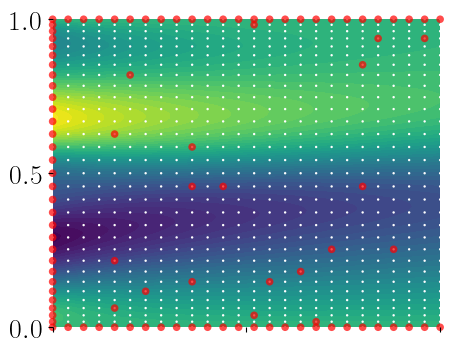

In [11]:
# u true with 20 obs
tx_all, u_all, tx_obs, u_obs = get_tx_all_obs(num_obs=20)
plt.figure(figsize=(5,4))
plt.tricontourf(*tx_fine.T, u_true,
                levels= 50)
# coll grid
plt.scatter(*tx_all.T,
            c='white',
            s = 3,
            clip_on =False, 
            edgecolors = 'none')
# obs grid
plt.scatter(*tx_obs.T,
            c='red', 
            s = 30, 
            alpha = 0.7,
            clip_on =False,
            edgecolors = 'none')

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
plt.gca().set_xticklabels([]) 

# save fig
plt.savefig('u_true_nobs1.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            )

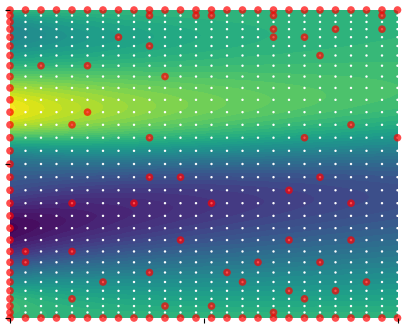

In [10]:
# u true with 50 obs
tx_all, u_all, tx_obs, u_obs = get_tx_all_obs(num_obs=50)
plt.figure(figsize=(5,4))
plt.tricontourf(*tx_fine.T, u_true,
                levels= 50)
# coll grid
plt.scatter(*tx_all.T,
            c='white',
            s = 3,
            clip_on =False, 
            edgecolors = 'none')
# obs grid
plt.scatter(*tx_obs.T,
            c='red', 
            s = 30, 
            alpha = 0.7,
            clip_on =False,
            edgecolors = 'none')

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([]) 

# save fig
plt.savefig('u_true_nobs2.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            )

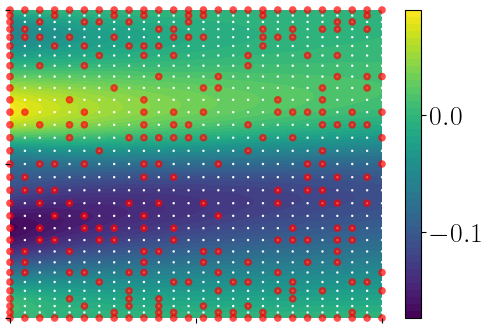

In [9]:
# u true with 200 obs
tx_all, u_all, tx_obs, u_obs = get_tx_all_obs(num_obs=200)
plt.figure(figsize=(6,4))
cp = plt.tricontourf(*tx_fine.T, u_true,
                levels= 50)
cb = plt.colorbar(cp)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()
# coll grid
plt.scatter(*tx_all.T,
            c='white',
            s = 3,
            clip_on =False, 
            edgecolors = 'none')
# obs grid
plt.scatter(*tx_obs.T,
            c='red', 
            s = 30, 
            alpha = 0.7,
            clip_on =False,
            edgecolors = 'none')

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([]) 

# save fig
plt.savefig('u_true_nobs3.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            )

## Loss history

In [8]:
tx_all, u_all, tx_obs, u_obs = get_tx_all_obs(num_obs=20)
# Run 1_5 step method
u_operators = (eval_k,dx_k,dt_k)
feature_operators = (eval_k,dx_k,dxx_k)

# Choose u kernel
def param_ani_gaussian_RBF(x,y,params):
    lengthscales = log1pexp(params)
    return get_anisotropic_gaussianRBF(1.,jnp.diag(lengthscales))(x,y)

fitted_params,ml_value = fit_kernel_params(param_ani_gaussian_RBF,
                                           tx_obs,
                                           u_obs,
                                           jnp.zeros(2))
ML_lengthscales = log1pexp(fitted_params)
# u kernel
k_u = get_anisotropic_gaussianRBF(0.75,
                                  jnp.diag(log1pexp(fitted_params))
)

# u RKHS
u_model = CholInducedRKHS(
    tx_all,
    u_operators,
    k_u,
    nugget_size = 1e-8
    )
# fit params of u
u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

grid_features_init = (
    (u_model.evaluate_operators(feature_operators,tx_int,u_params_init))
    .reshape(
            len(tx_int),
            len(feature_operators),
            order = 'F'
        )
)

# P kernel
k_P_u_part = get_centered_scaled_poly_kernel(2,grid_features_init,c=1.,scaling = 'diagonal')
@vectorize_kfunc
def k_P(x,y):
    return k_P_u_part(x[2:],y[2:])
# P RKHS
P_model = OperatorModel(k_P)

# u and P object
EqnModel = OperatorPDEModel(
    P_model,
    (u_model,),
    (tx_obs,),
    (u_obs,),
    (tx_int,),
    feature_operators,
    rhs_operator=dt_k,
    datafit_weight = 100
)

## OPTIMIZE

# init params
params_init = jnp.hstack([u_params_init,jnp.zeros(len(grid_features_init))])
# LM options
optparams = LMParams(max_iter = 201)
# run LM
params,convergence_data = CholeskyLM(params_init.copy(),
                                     EqnModel,
                                     beta = 1e-11,
                                     optParams = optparams
)
# run SVD-LM
p_adjusted,refine_convergence_data = SVD_LM(
    params,
    EqnModel,
    beta = 1e-11,
    optParams = optparams
)

# loss history
loss_vals_LM = convergence_data.loss_vals
loss_vals_SVDLM = refine_convergence_data.loss_vals

  1%|▏         | 3/201 [00:11<09:52,  2.99s/it]

Iteration 0, loss = 0.001456, gradnorm = 2.823, alpha = 2.5, improvement_ratio = 1.003
Iteration 1, loss = 0.001341, gradnorm = 1.139, alpha = 2.083, improvement_ratio = 1.011
Iteration 2, loss = 0.001277, gradnorm = 0.4863, alpha = 1.736, improvement_ratio = 1.014


  2%|▏         | 5/201 [00:11<04:52,  1.49s/it]

Iteration 3, loss = 0.001227, gradnorm = 0.2211, alpha = 1.447, improvement_ratio = 1.013
Iteration 4, loss = 0.001181, gradnorm = 0.1184, alpha = 1.206, improvement_ratio = 1.011
Iteration 5, loss = 0.001139, gradnorm = 0.0795, alpha = 1.005, improvement_ratio = 1.009


 26%|██▋       | 53/201 [00:15<00:10, 13.92it/s]

Iteration 50, loss = 4.728e-05, gradnorm = 0.003255, alpha = 0.0003297, improvement_ratio = 1.016


 51%|█████     | 103/201 [00:18<00:07, 13.96it/s]

Iteration 100, loss = 7.467e-06, gradnorm = 1.815e-05, alpha = 3.622e-08, improvement_ratio = 1.0


 76%|███████▌  | 153/201 [00:22<00:03, 13.96it/s]

Iteration 150, loss = 4.287e-06, gradnorm = 1.086e-06, alpha = 8.333e-09, improvement_ratio = 1.0


100%|██████████| 201/201 [00:25<00:00,  7.83it/s]


Iteration 200, loss = 4.022e-06, gradnorm = 9.125e-07, alpha = 8.333e-09, improvement_ratio = 1.0


  0%|          | 1/201 [00:11<37:49, 11.35s/it]

Iteration 0, loss = 4.022e-06, gradnorm = 9.094e-07, alpha = 2.463e+03, improvement_ratio = 189.5


  0%|          | 1/201 [00:11<39:07, 11.74s/it]

Line Search Failed!
Final Iteration Results
Iteration 1, loss = 4.022e-06, gradnorm = 9.094e-07, alpha = 1.995e+05, improvement_ratio = -1.676e+04


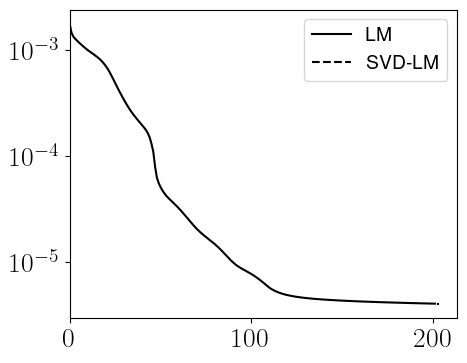

: 

In [10]:
# loss history plot
plt.figure(figsize=(5,4))
plt.plot(range(len(loss_vals_LM)),
         loss_vals_LM,
         color = 'black',
         ls = 'solid',
         label = 'LM'
)
plt.plot(jnp.arange(len(loss_vals_LM),
                    len(loss_vals_LM) + len(loss_vals_SVDLM)),
        loss_vals_SVDLM,
        color = 'black',
        ls = 'dashed',
        label = 'SVD-LM'
)

# fig settings
plt.locator_params(axis="x", nbins=3)
plt.locator_params(axis="y", nbins=2)
plt.xlim(left=0)
plt.yscale('log')
plt.minorticks_off()
plt.legend(loc="upper right",fontsize = 14)
#save fig
plt.savefig('fixedIC_loss_vals.pdf', 
            bbox_inches='tight',
            format = 'pdf',
            dpi=300)